In [4]:
import pandas as pd
import numpy as np

import glob
from ase.io import read
from dscribe.descriptors import ACSF

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import pylab as pl


import random
import sys

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics

from pandas import set_option
pd.options.mode.chained_assignment = None

from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from scipy.stats import truncnorm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [31]:
def ML_train(X_tr, y_tr, X_te, y_te):
    rstate = random.randrange(1,999999999,1)
    estimator = RandomForestRegressor(random_state = rstate, n_estimators = 25, min_samples_split = 100, n_jobs = 10)
    train = estimator.fit(X_tr, y_tr)
    pred = estimator.predict(X_te)
    
    # Cross validation 
    cvscore = cross_val_score(estimator, X_tr, y_tr, cv=5, n_jobs=10)
    score = cvscore.mean()
    print("Score with the entire dataset = %.2f" % score)
    print("mean absolute error: ", mean_absolute_error(y_tr, estimator.predict(X_tr)))
    print("mean squared error: ", mean_squared_error(y_tr, estimator.predict(X_tr)))
    print("r2 score: ", r2_score(y_tr, estimator.predict(X_tr)))

In [6]:
def ML_Pred(estimator, X_te, y_te):
    pred = estimator.predict(X_te)
    
    print("Evaluate the error on the test data.")
    print("mean absolute error: ", mean_absolute_error(y_te, pred))
    print("mean squared error: ", mean_squared_error(y_te,pred))
    print("r2 score: ", r2_score(y_te, pred))
    return pred

In [7]:
aN={1:'H',6:'C',7:'N',8:'O',20:'Ca'}

In [9]:
testsize = 0.3
rstate=random.randrange(1,999999999,1)



# Machine learning function
def RFR_atom(train_data, test_data):
    # to use the same random number in data shuffling for reproducible results
    # rstate = random.randrange(1,999999999,1)
    X_train = train_data[:,:-2]
    y_train = train_data[:,-1]
    
    X_test = test_data[:,:-2]
    y_test = test_data[:,-1]
    #X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = testsize, random_state = rstate)
    estimator = ML_train(X_train, y_train, X_test, y_test)
    return estimator

In [11]:
class Structure:
    
    def __init__(self, pdb_path):
        self.name = pdb_path.split('/')[1].split('.pdb')[0]
        self.water = int(self.name.split('.')[2][5:])
        self.system = self.name.split('.')[0]
        self.loop = self.name.split('.')[1]
        self.mdframe = self.name.split('.')[3]
        self.feat_atom=dict()
        #print("PDB name is ", self.name)
        
    def calc_sym(self):
        '''
        The function takes the structure file and compute the 
        symmetry function for each atom
        output: a list of symmetry functions for each atom. 
                Length of the list = number of atoms
            UPDATE: remove water molecules.
        ''' 
        pdb_file = self.name+'.pdb'
        chg_file = self.name + '.chg'
        structure = read("pdb/"+pdb_file)
        feat_lst=[]
        num=structure.get_global_number_of_atoms()
        atomPos = [x for x in range(0,num)]

        chg=np.genfromtxt("charge/"+chg_file)


        #for r_cut in [x/4. for x in range(4,13,1)]:
         
        # Setting up the ACSF descriptor
        for r_cut in [3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]:
            acsf = ACSF(
                species=["C", "H", "O", "N", "Ca"],
                rcut=r_cut,
                g2_params=[[0.0001,0]],
            )
            feat_lst.append(acsf.create(structure,positions=atomPos,n_jobs=4))

        acsf_ang = ACSF(
            species=["C", "H", "O", "N", "Ca"],
            rcut=6.0,
            g4_params=[[0.0001,0.5,-1]],
        )
        #feat_lst.append(acsf_ang.create(structure,positions=atomPos,n_jobs=4))

        feat = np.hstack(tuple(feat_lst))
        dat = np.hstack((feat,chg))
        np.savetxt('sym/sym_'+pdb_file[0:-4]+'.dat', dat, delimiter=',')
        
        # Skip water here
        # Skip to the last water x 3 rows
        skip_water = -3 * self.water
        # If there is no water, skip none (-1)
        if skip_water == 0:
            skip_water = None
        #print("skip water atoms",skip_water)
        #print(dat.shape)
        #print(dat[:skip_water,:].shape)
        for i in dat[:skip_water,:]:
            ikey = aN[int(i[-2])]
            if ikey in self.feat_atom:
                self.feat_atom[ikey] = np.vstack((self.feat_atom[ikey],i))
            else:
                #print(ikey,"is not in the dictionary, adding ...")
                self.feat_atom[ikey] = i
        
    # crudely add the network parameters
    def get_network(self):
        network_file = 'network/net.'+self.name+'.csv'
        net = pd.read_csv(network_file)
        return np.array(net.iloc[:,1:]).flatten()

In [12]:

# Use all the files
loops = glob.glob("pdb/*.pdb")
structures = dict()
counter = 0
count_total = len(loops)
for loop in loops:
    name = loop.split('/')[1].split('.pdb')[0]
    structures[name]=Structure(loop)
    structures[name].calc_sym()
    
    # adding the 14x4 network parameters to the left of the feat matrix
    #net = structures[name].get_network()
    #structures[name].feat_atom['Ca'] = np.hstack((net,structures[name].feat_atom['Ca']))


    counter = counter + 1
    if counter % 100 == 0:
        #sys.stdout.write('\r')
        print(counter, "structures out of ", count_total, " processed ...", end = '\r')
        sys.stdout.flush()

In [13]:
# Split the data into train and data
name=np.array([i for i in structures.keys()])
struct_Train, struct_Test = train_test_split(name, test_size = testsize, random_state = rstate)

In [14]:
# Put data in the train, test dicts.
# Data sorted as for elements
# TODO: Need to exclude water molecules from the list
# because charges for the water molecules are fixed.
# aN = {20:'Ca'}


# Split the data for c and n loops
# structures[loop_name].loop = '1' or '2' --> n loop
# structures[loop_name].loop = '3' or '4' --> c loop

Train_Data_atom_N = dict()
Train_Data_atom_C = dict()


for loop_name in struct_Train:
    #print(loop_name)
    if structures[loop_name].loop == 'loop1' or structures[loop_name].loop == 'loop2':
        for ele in aN.values():
            if ele in Train_Data_atom_N:
                Train_Data_atom_N[ele] = np.vstack((Train_Data_atom_N[ele],structures[loop_name].feat_atom[ele]))
            else:
                Train_Data_atom_N[ele] = structures[loop_name].feat_atom[ele]
    if structures[loop_name].loop == 'loop3' or structures[loop_name].loop == 'loop4':
        for ele in aN.values():
            if ele in Train_Data_atom_C:
                Train_Data_atom_C[ele] = np.vstack((Train_Data_atom_C[ele],structures[loop_name].feat_atom[ele]))
            else:
                Train_Data_atom_C[ele] = structures[loop_name].feat_atom[ele]

Test_Data_atom_N = dict()
Test_Data_atom_C = dict()


for loop_name in struct_Test:
    #print(loop_name)
    if structures[loop_name].loop == 'loop1' or structures[loop_name].loop == 'loop2':
        for ele in aN.values():
            if ele in Test_Data_atom_N:
                Test_Data_atom_N[ele] = np.vstack((Test_Data_atom_N[ele],structures[loop_name].feat_atom[ele]))
            else:
                Test_Data_atom_N[ele] = structures[loop_name].feat_atom[ele]
    if structures[loop_name].loop == 'loop3' or structures[loop_name].loop == 'loop4':
        for ele in aN.values():
            if ele in Test_Data_atom_C:
                Test_Data_atom_C[ele] = np.vstack((Test_Data_atom_C[ele],structures[loop_name].feat_atom[ele]))
            else:
                Test_Data_atom_C[ele] = structures[loop_name].feat_atom[ele]


In [94]:
# Testing models for 1 set of data
train_data = Train_Data_atom_N['Ca']
test_data = Test_Data_atom_N['Ca']

X_tr = train_data[:,:-2]
y_tr = train_data[:,-1]
    
X_te = test_data[:,:-2]
y_te = test_data[:,-1]

#scaler = preprocessing.StandardScaler().fit(X_tr)

#X_tr = scaler.transform(X_tr)

In [85]:
from sklearn import svm
regr = svm.SVR(gamma='auto')
regr.fit(X_tr, y_tr)
pred = regr.predict(X_te)

regr.score(X_te,y_te)
print(mean_absolute_error(y_te, pred))
print(r2_score(y_te, pred))

0.07892056749787404
-0.32426751868970216


In [86]:
from sklearn import svm
from sklearn.ensemble import AdaBoostRegressor
regr = AdaBoostRegressor(svm.SVR(gamma='scale'), n_estimators=10, random_state=0)
regr.fit(X_tr, y_tr)
pred = regr.predict(X_te)
regr.score(X_tr, y_tr)
print(mean_absolute_error(y_te, pred))
print(r2_score(y_te, pred))

0.06446909555138877
0.014239398021668181


In [111]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor

rstate = 1337

regr = BaggingRegressor(base_estimator=SVR(gamma='auto'), n_estimators=100, random_state=0)
pipe = make_pipeline(preprocessing.StandardScaler(), regr)
pipe.fit(X_tr, y_tr)  # apply scaling on training data

#train = estimator.fit(X_tr, y_tr)
#pred = estimator.predict(X_te)

pred = pipe.predict(X_te)

# Cross validation 
cvscore = cross_val_score(pipe, X_tr, y_tr, cv=5, n_jobs=10)
score = cvscore.mean()
print("Score with the entire dataset = %.2f" % score)
print("mean absolute error: ", mean_absolute_error(y_tr, pipe.predict(X_tr)))
print(r2_score(y_te, pred))

Score with the entire dataset = 0.25
mean absolute error:  0.04999663544953921
0.2816581201925946


In [114]:
from sklearn.pipeline import make_pipeline
rstate = 1337
estimator = RandomForestRegressor(random_state = rstate, criterion = 'mae', n_estimators = 100, oob_score = True, n_jobs = 10)
pipe = make_pipeline(preprocessing.StandardScaler(), estimator)
pipe.fit(X_tr, y_tr)  # apply scaling on training data

#train = estimator.fit(X_tr, y_tr)
#pred = estimator.predict(X_te)

pred = pipe.predict(X_te)

# Cross validation 
cvscore = cross_val_score(pipe, X_tr, y_tr, cv=5, n_jobs=10)
score = cvscore.mean()
print("Score with the entire dataset = %.2f" % score)
print("mean absolute error: ", mean_absolute_error(y_tr, pipe.predict(X_tr)))
print(r2_score(y_te, pred))

Score with the entire dataset = 0.31
mean absolute error:  0.01776088737831482
0.32355331402411125


In [117]:
mean_absolute_error(y_tr, pipe.predict(X_tr))
r2_score(y_tr, pipe.predict(X_tr))

0.9069248333350703

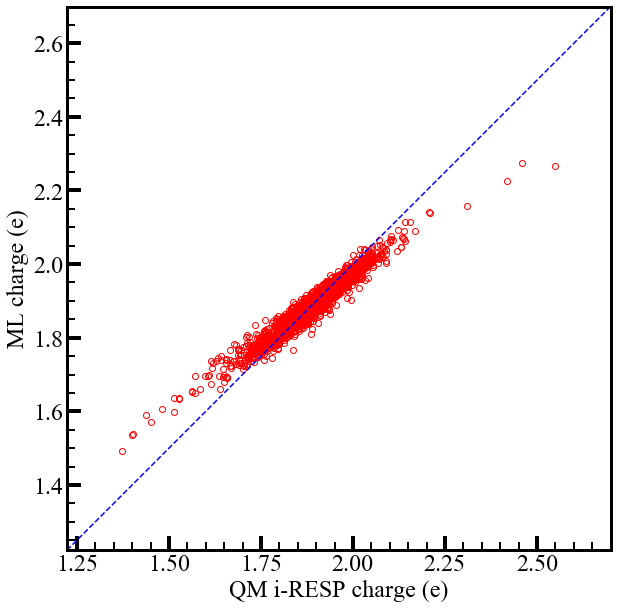

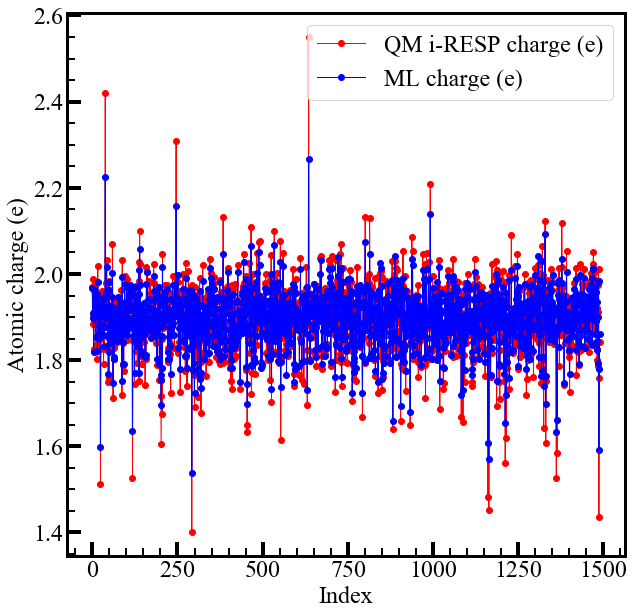

In [116]:
Caplot = MLPlot(Train_Data_atom_N['Ca'], pipe)
Caplot.corrplot()
Caplot.cmplot()

In [33]:
# ML models for each element out of 70% of the data
estimator=dict()
for ele in Train_Data_atom_N:
    print("Training for atoms according to the element: ", ele)
    estimator[ele] = RFR_atom(Train_Data_atom_N[ele], Test_Data_atom_N[ele])
    print("\n")

if True:

    for ele in Train_Data_atom_C:
        print("Training for atoms according to the element: ", ele)
        estimator[ele] = RFR_atom(Train_Data_atom_C[ele], Test_Data_atom_C[ele])
        print("\n")

Training for atoms according to the element:  H
Score with the entire dataset = 0.67
mean absolute error:  0.04963766862564809
mean squared error:  0.005669402926251909
r2 score:  0.7586897618178526


Training for atoms according to the element:  C
Score with the entire dataset = 0.78
mean absolute error:  0.15378533357930227
mean squared error:  0.04369835631381147
r2 score:  0.8376698431017627


Training for atoms according to the element:  N
Score with the entire dataset = 0.59
mean absolute error:  0.15928873118528863
mean squared error:  0.045310529676815675
r2 score:  0.6937159500222083


Training for atoms according to the element:  O
Score with the entire dataset = 0.65
mean absolute error:  0.051503638817880115
mean squared error:  0.005561360772409903
r2 score:  0.7465911992313805


Training for atoms according to the element:  Ca
Score with the entire dataset = 0.29
mean absolute error:  0.04310284317141348
mean squared error:  0.003823575476155257
r2 score:  0.4632499848400

In [53]:
help(RandomForestRegressor)

Help on class RandomForestRegressor in module sklearn.ensemble.forest:

class RandomForestRegressor(ForestRegressor)
 |  A random forest regressor.
 |  
 |  A random forest is a meta estimator that fits a number of classifying
 |  decision trees on various sub-samples of the dataset and uses averaging
 |  to improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators : integer, optional (default=10)
 |      The number of trees in the forest.
 |  
 |      .. versionchanged:: 0.20
 |         The default value of ``n_estimators`` will change from 10 in
 |         version 0.20 to 100 in version 0.22.
 |  
 |  criterion : string, optional (default="mse")
 |      The function to measure the quality of a split. Supported criteria
 |  

In [26]:
Train_Data_atom_N[ele].shape

(245449, 72)

In [90]:
class MLPlot:
    
    # Edit the font, font size, and axes width
    mpl.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 24
    plt.rcParams['axes.linewidth'] = 3
    
    def __init__(self, MLdata, MLestimator):
        X = MLdata[:,:-2]
        y = MLdata[:,-1]
        #X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = testsize, random_state = rstate)
        #self.qm = y_test
        #self.ml = MLestimator.predict(X_test)
        self.qm = y
        self.ml = MLestimator.predict(X)
        
    # Plot outputs
    def corrplot(self):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot()

        plt.plot(self.qm, self.ml,'ro',fillstyle='none')
        
        # determine the range
        qm_max=np.max(self.qm)
        qm_min=np.min(self.qm)
        ml_max=np.max(self.ml)
        ml_min=np.min(self.ml)
        sigma=np.std(self.qm)+np.std(self.ml)
        ax_low=min(qm_min,ml_min)-sigma
        ax_up=max(qm_max,ml_max)+sigma
        
        plt.xlim(ax_low,ax_up)
        plt.ylim(ax_low,ax_up)
        plt.plot([ax_low,ax_up],[ax_low,ax_up], '--b')

        plt.xlabel('QM i-RESP charge (e)')
        plt.ylabel('ML charge (e)')
        
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='both', which='major', direction='in', length=14, width=4, color='k')
        ax.tick_params(axis='both', which='minor', direction='in', length=8, width=2, color='k')


        #ax.xaxis.grid(True, which='minor')
        # square figure
        ax.set_aspect('equal', adjustable='box')
        plt.show()
    
    
    def cmplot(self):
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot()
        skip = int(len(self.qm)/1000)
        plt.plot(self.qm[::skip], color='red', marker='o', linewidth=1, label = 'QM i-RESP charge (e)')
        plt.plot(self.ml[::skip], color='blue', marker='o', linewidth=1, label = 'ML charge (e)')
        plt.legend(loc='best')
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='both', which='major', direction='in', length=14, width=4, color='k')
        ax.tick_params(axis='both', which='minor', direction='in', length=8, width=2, color='k')
        
        plt.xlabel('Index')
        plt.ylabel('Atomic charge (e)')
        plt.show()

In [11]:
# Chopping the data for validation
if False:
    X_train_total_size = X_train.shape[0]
    chunk = 1
    chunk_size = int(X_train_total_size / chunk)
    for i in range(chunk):
        row = 1 + i*chunk_size + chunk_size
        sub_X_train = X_train[0:row,:]
        sub_y_train = y_train[0:row]
        ML_train(sub_X_train,sub_y_train,X_test,y_test)

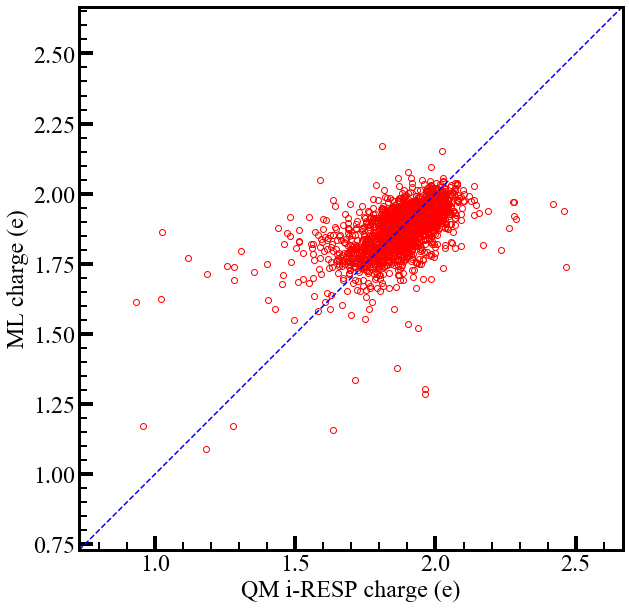

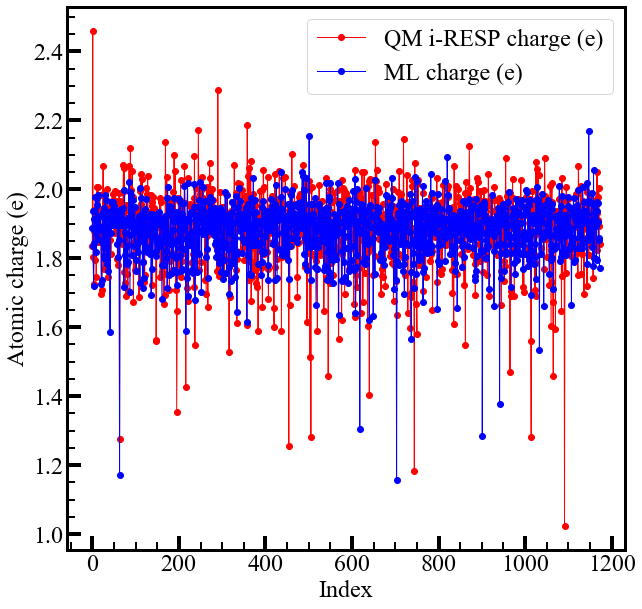

In [12]:
Caplot = MLPlot(Test_Data_atom['Ca'], estimator['Ca'])
Caplot.corrplot()
Caplot.cmplot()

In [13]:
# Now investigate what happens to structures with large number of water molecules
# First collecting the structures.

Data_atom_sub = dict()
for loop_name in struct_Test:
    struct = structures[loop_name]
    for ele in struct.feat_atom:
        tup_key = (ele, struct.water)
        if tup_key in Data_atom_sub:
            Data_atom_sub[tup_key] = np.vstack((Data_atom_sub[tup_key], struct.feat_atom[ele]))
        else:
            Data_atom_sub[tup_key] = struct.feat_atom[ele]

In [31]:
for group in Data_atom_sub:
    print("\nchecking group of structures with", group[1], "for", group[0], "atoms")
    MLdata = Data_atom_sub[group]
    MLestimator = estimator[group[0]]
    X = MLdata[:,:-2]
    y = MLdata[:,-1]
    pred = MLestimator.predict(X)
    print("Evaluate the error.")
    print("mean absolute error: ", mean_absolute_error(y, pred))
    print("mean squared error: ", mean_squared_error(y,pred))
    print("r2 score: ", r2_score(y, pred))



checking group of structures with 2 for C atoms


KeyError: 'C'

In [ ]:
# Evaluate distribution of the QM charges in the test set
for ele, feat in Test_Data_atom.items():
    _ = plt.hist(feat[:,-1], bins='auto')
    plt.title("Histogram of " + ele + " atoms in the test set")
    plt.show()

In [ ]:
# Evaluate distribution of the QM charges in the training set
for ele, feat in Train_Data_atom.items():
    _ = plt.hist(feat[:,-1], bins='auto')
    plt.title("Histogram of " + ele + " atoms in the training set")
    plt.show()

In [ ]:
# Evaluate distribution of the QM charges in the test set
# According to number of waters
    
water012 = dict()
water3_8 = dict()

for loop_name in struct_Test:
    feat = structures[loop_name].feat_atom
    if structures[loop_name].water < 3:
        for item in feat:
            if item not in water012:
                water012[item] = feat[item]
            else:
                water012[item] = np.vstack((water012[item], feat[item]))
    else:
        for item in feat:
            if item not in water3_8:
                water3_8[item] = feat[item]
            else:
                water3_8[item] = np.vstack((water3_8[item], feat[item]))



In [ ]:
for ele in water012:
    print("\nchecking group of structures with <3 water molecules for", ele, "atoms")
    MLdata = water012[ele]
    MLestimator = estimator[ele]
    X = MLdata[:,:-2]
    y = MLdata[:,-1]
    pred = MLestimator.predict(X)
    print("Evaluate the error.")
    print("mean absolute error: ", mean_absolute_error(y, pred))
    print("mean squared error: ", mean_squared_error(y,pred))
    print("r2 score: ", r2_score(y, pred))


In [ ]:
for ele in water3_8:
    print("\nchecking group of structures with >= 3 water molecules for", ele, "atoms")
    MLdata = water3_8[ele]
    MLestimator = estimator[ele]
    X = MLdata[:,:-2]
    y = MLdata[:,-1]
    pred = MLestimator.predict(X)
    print("Evaluate the error.")
    print("mean absolute error: ", mean_absolute_error(y, pred))
    print("mean squared error: ", mean_squared_error(y,pred))
    print("r2 score: ", r2_score(y, pred))


In [ ]:
plt.figure#(figsize=(5, 10))
fig, axs = plt.subplots(5,2)
cnt = 0
for ele in water012:
    chg = water012[ele][:,-1]
    axs[cnt,0].hist(chg, bins='auto')
#    axs[cnt,0].title("Histogram of " + ele + " atoms with <3 H2O in the test set")
    cnt = cnt + 1
#    plt.show()

cnt = 0
for ele in water3_8:
    chg = water3_8[ele][:,-1]
    axs[cnt,1].hist(chg, bins='auto')
 #   axs[cnt,1].title("Histogram of " + ele + " atoms with >=3 H2O in the test set")
    cnt = cnt + 1
#    plt.show()